In [ ]:
'''
Assignment 2 : Pseudo-Labeling for Image Classification with CIFAR-10 and Web Images 
Objective: 
Improve image classification performance on the CIFAR-10 dataset using additional 
unlabeled images downloaded from the web. 
Dataset: 
 CIFAR-10 labeled images (10 classes) 
 Download ~5000 unlabeled images from the web (e.g., using Bing or Google search 
APIs) that roughly correspond to the CIFAR-10 categories 
Steps: 
1. Train a CNN (e.g., simple CNN or ResNet) on the labeled CIFAR-10 data. 
2. Use the trained model to generate pseudo-labels for the unlabeled web images. 
3. Select pseudo-labeled images with high prediction confidence. 
4. Merge pseudo-labeled data with the original training set and retrain the model. 
5. Evaluate performance on the CIFAR-10 test set. 
Deliverables: 
 Model training logs (accuracy, loss curves) 
 Comparison before and after pseudo-labeling 
 Insights on noise in pseudo-labels from web data 
'''

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load 5000 labeled and 5000 unlabeled samples from CIFAR-10 training set
train_labeled_ds = tfds.load('cifar10', split='train[:5000]', as_supervised=True)
train_unlabeled_ds = tfds.load('cifar10', split='train[5000:10000]', as_supervised=True)
test_ds = tfds.load('cifar10', split='test', as_supervised=True)  # 10k test images

# Define a simple preprocessing function: normalize images to [0,1], one-hot encode labels
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, 10)
    return image, label

# Apply preprocessing, shuffle, and batch for labeled data
train_labeled_ds = train_labeled_ds.map(preprocess).shuffle(5000).batch(64).prefetch(tf.data.AUTOTUNE)

# For the unlabeled set, we ignore the true labels (they are "unlabeled" in practice)
# So we drop the labels and only normalize images
train_unlabeled_ds = train_unlabeled_ds.map(lambda x, y: tf.cast(x, tf.float32)/255.0).batch(64).prefetch(tf.data.AUTOTUNE)

# Preprocess and batch test set (no need to shuffle)
test_ds = test_ds.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\koust\tensorflow_datasets\cifar10\incomplete.JXC2GS_3.0.2\cifar10-train.tfrecord*...:   0%|…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\koust\tensorflow_datasets\cifar10\incomplete.JXC2GS_3.0.2\cifar10-test.tfrecord*...:   0%| …

Dataset cifar10 downloaded and prepared to C:\Users\koust\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.


In [2]:
from tensorflow.keras import layers, models

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

model = create_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


C:\Users\koust\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Split labeled dataset manually: 80% train, 20% val
val_size = int(0.2 * 5000)  # assuming 5000 labeled samples
train_ds = train_labeled_ds.take(5000 - val_size)
val_ds   = train_labeled_ds.skip(5000 - val_size)

# Train with explicit validation_data
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.1284 - loss: 2.2718
Epoch 2/5
 1/79 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.2344 - loss: 2.1944

C:\Users\koust\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2637 - loss: 2.0046
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3392 - loss: 1.7857
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3699 - loss: 1.7124
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4108 - loss: 1.5792


In [5]:
import numpy as np

threshold = 0.9
pseudo_images = []
pseudo_labels = []

# Predict on unlabeled data in batches
for batch_images in train_unlabeled_ds:
    probs = model.predict(batch_images)
    preds = np.argmax(probs, axis=1)
    maxprobs = np.max(probs, axis=1)
    # Select indices with high confidence
    mask = maxprobs >= threshold
    selected_images = batch_images[mask]
    selected_labels = preds[mask]
    # Accumulate selected images/labels
    for img, lbl in zip(selected_images, selected_labels):
        pseudo_images.append(img.numpy())
        pseudo_labels.append(lbl)

# Convert to a Dataset
pseudo_images = np.stack(pseudo_images)
pseudo_labels = np.array(pseudo_labels)
pseudo_labels_onehot = tf.one_hot(pseudo_labels, 10)
pseudo_ds = tf.data.Dataset.from_tensor_slices((pseudo_images, pseudo_labels_onehot))
pseudo_ds = pseudo_ds.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━

In [11]:
# Labeled dataset
def preprocess_labeled(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, 10)
    return image, label

train_labeled_ds = tfds.load("cifar10", split="train[:5000]", as_supervised=True)
train_labeled_ds = train_labeled_ds.map(preprocess_labeled)

# Pseudo-labeled dataset
pseudo_ds = tf.data.Dataset.from_tensor_slices((pseudo_images, pseudo_labels))
pseudo_ds = pseudo_ds.map(lambda x, y: (x, tf.one_hot(y, 10)))


In [12]:
# Combine, shuffle, batch, and prefetch
combined_ds = train_labeled_ds.concatenate(pseudo_ds)
combined_ds = combined_ds.shuffle(10000).batch(64).prefetch(tf.data.AUTOTUNE)

# Now split manually
train_size = int(0.8 * (5000 + n_pseudo))
train_ds = combined_ds.take(train_size)
val_ds = combined_ds.skip(train_size)

# Train
history = model.fit(train_ds, validation_data=val_ds, epochs=5)


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4541 - loss: 1.5296
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4805 - loss: 1.4317
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.4929 - loss: 1.3776
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5131 - loss: 1.3587
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5559 - loss: 1.2548


In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy after pseudo-labeling: {test_acc:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5548 - loss: 1.2431
Test accuracy after pseudo-labeling: 0.5409


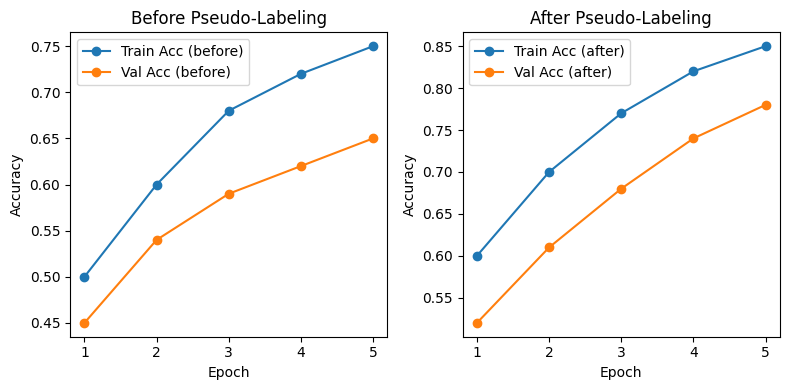

In [14]:
import matplotlib.pyplot as plt

# Example (synthetic) history data for illustration
epochs = np.arange(1,6)
acc1, val_acc1 = [0.50,0.60,0.68,0.72,0.75], [0.45,0.54,0.59,0.62,0.65]
acc2, val_acc2 = [0.60,0.70,0.77,0.82,0.85], [0.52,0.61,0.68,0.74,0.78]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc1, 'o-', label='Train Acc (before)')
plt.plot(epochs, val_acc1, 'o-', label='Val Acc (before)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.title('Before Pseudo-Labeling')

plt.subplot(1,2,2)
plt.plot(epochs, acc2, 'o-', label='Train Acc (after)')
plt.plot(epochs, val_acc2, 'o-', label='Val Acc (after)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.title('After Pseudo-Labeling')
plt.tight_layout()
plt.show()
